# Import Libraries

In [1]:
import math
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from math import sqrt
from pandas import concat
from datetime import datetime
from matplotlib import pyplot
from keras.models import Sequential
from numpy import concatenate, asarray
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# ----- Data Pre-Processing -----

In [2]:
coffee_data = pd.read_excel('coffee_data.xlsx')
fuel_data = pd.read_excel('fuel_data.xlsx')
#tomato_data = pd.read_excel('tomato_data.xls')
weather_data = pd.read_excel('BuonMaThuot.xlsx')

### Filter Coffee data

In [3]:
coffee_data['Ngày'] = pd.to_datetime(coffee_data['Ngày'])
coffee_data = coffee_data.set_index('Ngày').resample('D').ffill().reset_index()
coffee_data.head(5)

,Ngày,Giá Cà Phê
0,2021-01-01,31667.5
1,2021-01-02,31667.5
2,2021-01-03,31667.5
3,2021-01-04,32717.0
4,2021-01-05,32417.0


### Filter Diesel data

In [4]:
fuel_data["Ngày"] = pd.to_datetime(fuel_data["Giá nhiên liệu"], format="%d.%m.%Y")
fuel_data.drop(fuel_data.columns[[0,1]], axis='columns', inplace=True)
# reverse the order
fuel_data = fuel_data[::-1]
fuel_data.head(5)

,Dầu Diesel 1 lít,Ngày
118,14900.0,2019-01-01
117,14900.0,2019-01-16
116,14900.0,2019-01-31
115,14900.0,2019-02-15
114,15860.0,2019-03-02


### Filter Weather Data

In [5]:
weather_data["time"] = pd.to_datetime(weather_data["time"], format="%d.%m.%Y")
weather_data.head(5)

,time,temperature_2m_mean (°C),precipitation_sum (mm)
0,2018-01-01,21.183332,0.0
1,2018-01-02,21.558332,0.0
2,2018-01-03,22.604166,0.0
3,2018-01-04,23.062494,3.6
4,2018-01-05,23.937500,0.3


In [6]:
# Total precipitation by each year

year2018 = (weather_data['time'] >= '2018-1-1') & (weather_data['time'] <= '2018-12-31')
df2 = weather_data.loc[year2018]
prec2018 = df2["precipitation_sum (mm)"].sum()

year2019 = (weather_data['time'] >= '2019-1-1') & (weather_data['time'] <= '2019-12-31')
df2 = weather_data.loc[year2019]
prec2019 = df2["precipitation_sum (mm)"].sum()

year2020 = (weather_data['time'] >= '2020-1-1') & (weather_data['time'] <= '2020-12-31')
df2 = weather_data.loc[year2020]
prec2020 = df2["precipitation_sum (mm)"].sum()

year2021 = (weather_data['time'] >= '2021-1-1') & (weather_data['time'] <= '2021-12-31')
df2 = weather_data.loc[year2021]
prec2021 = df2["precipitation_sum (mm)"].sum()

year2022 = (weather_data['time'] >= '2022-1-1') & (weather_data['time'] <= '2022-12-31')
df2 = weather_data.loc[year2022]
prec2022 = df2["precipitation_sum (mm)"].sum()

# ----- Merge Data -----

In [7]:
# daterng_all = pd.date_range(start=fuel_data['Ngày'].iloc[-1], end=fuel_data['Ngày'].iloc[0], freq="1D")
# fuel_data = fuel_data.set_index('Ngày').resample('D').ffill().reset_index()

In [8]:
# Merge the dataframes with an outer join
merged_df = pd.merge(coffee_data, fuel_data, left_on='Ngày', right_on='Ngày', how="outer")

# Fill missing dates from both datasets with each other
merged_df.fillna(method='bfill', inplace=True)

In [9]:
# Create new column
merged_df['precipitation'] = ""

In [10]:
# Fill in weather value

# precipitation
merged_df['precipitation'] = np.where(merged_df['Ngày'] >= '2021-1-1', 
                                      prec2020 + prec2019 + prec2018, 
                                      merged_df['precipitation'])

merged_df['precipitation'] = np.where(merged_df['Ngày'] >= '2022-1-1', 
                                      prec2021 + prec2020 + prec2019, 
                                      merged_df['precipitation'])

merged_df['precipitation'] = np.where(merged_df['Ngày'] >= '2023-1-1', 
                                      prec2022 + prec2021 + prec2020, 
                                      merged_df['precipitation'])

In [11]:
merged_df = merged_df.dropna() # Drop N/A rows
data = merged_df

# convert to float
data['precipitation'] = data['precipitation'].astype(float)

# final dataset
data

,Ngày,Giá Cà Phê,Dầu Diesel 1 lít,precipitation
0,2021-01-01,31667.5,12640.0,3220.499994
1,2021-01-02,31667.5,12640.0,3220.499994
2,2021-01-03,31667.5,12640.0,3220.499994
3,2021-01-04,32717.0,12640.0,3220.499994
4,2021-01-05,32417.0,12640.0,3220.499994
...,...,...,...,...
864,2023-05-15,55566.5,14900.0,3734.200018
865,2023-05-16,56066.5,14900.0,3734.200018
866,2023-05-17,56666.5,14900.0,3734.200018
867,2023-05-18,57000.0,14900.0,3734.200018


# ----- Data Visualization -----

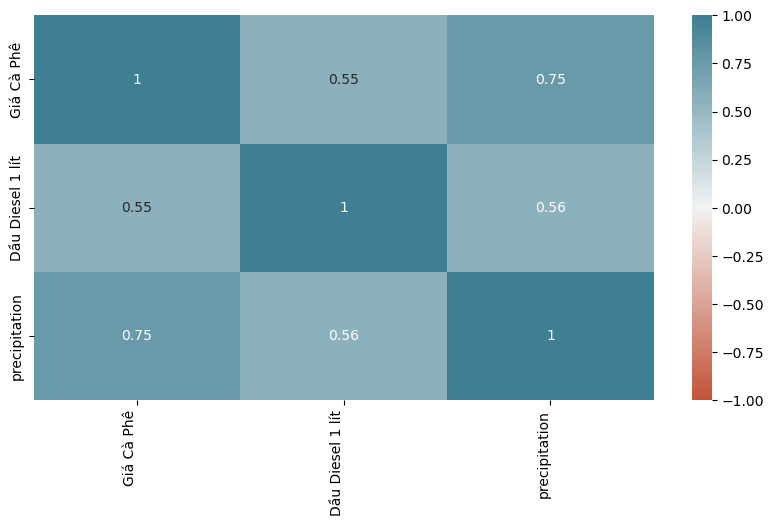

In [12]:
# # Use heatmap to identify correlation between variables
f, ax = plt.subplots(figsize = (10, 5))
corr = data.corr()
ax = sns.heatmap(
    corr, vmin = -1, vmax = 1, center = 0, annot = True,
    cmap = sns.diverging_palette(20, 220, n = 200),
    square = False
)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, horizontalalignment = 'right');

In [13]:
# fix random seed for reproducibility
tf.random.set_seed(7)

# ----- Normalization -----

In [14]:
# drop date column
data.drop(data.columns[[0]], axis=1, inplace=True)
data.dropna()

,Giá Cà Phê,Dầu Diesel 1 lít,precipitation
0,31667.5,12640.0,3220.499994
1,31667.5,12640.0,3220.499994
2,31667.5,12640.0,3220.499994
3,32717.0,12640.0,3220.499994
4,32417.0,12640.0,3220.499994
...,...,...,...
864,55566.5,14900.0,3734.200018
865,56066.5,14900.0,3734.200018
866,56666.5,14900.0,3734.200018
867,57000.0,14900.0,3734.200018


In [15]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [16]:
# set number of days
look_back = 7
predict_ahead = 1 

# frame as supervised learning
reframed = series_to_supervised(data.values, look_back, predict_ahead)

In [17]:
# calculate total column to keep
data_column = len(data.columns)
keep_column = look_back * data_column + 1

# drop columns we don't want to predict
reframed = reframed.drop(reframed.iloc[:, keep_column::],axis = 1) 
dataset = reframed

In [18]:
# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(reframed)
scaled.shape

(862, 22)

# ----- Split data -----

In [19]:
dataset = scaled

# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[:train_size,:], dataset[train_size:len(dataset),:]

print(len(train), len(test))

689 173


In [20]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(689, 1, 21) (689,) (173, 1, 21) (173,)


# ----- Train Model -----

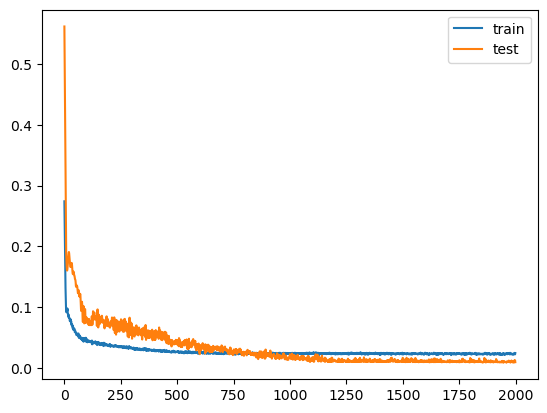

In [21]:
# design network
model = Sequential()
# model.add(LSTM(32, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dropout(0.5))
model.add(LSTM(16, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=2000, batch_size=256, 
                    validation_data=(test_X, test_y), verbose=False, shuffle=False)

# Note
# Large batch size: increase time, lower accuracy, overfit

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Results Analysis

In [22]:
# calculate metrics
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = sklearn.metrics.mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

def print_metrics(test, pre_test):
    
    print('\nRMSE')
    testScore = np.sqrt(mean_squared_error(test,pre_test))
    print('Test Score: %.2f RMSE' % (testScore))
    
    print('\nMAE')
    testScore = sklearn.metrics.mean_absolute_error(test, pre_test)
    print('Test Score: %.2f MAE' % (testScore))
    
    print('\nMAPE')                          
    testScore = sklearn.metrics.mean_absolute_percentage_error(test, pre_test)
    print('Test Score: %.2f MAPE' % (testScore))
    
    print('\nMASE')
    testScore = mean_absolute_scaled_error(test, pre_test, test)
    print('Test Score: %.2f MASE' % (testScore))

In [23]:
# make a prediction
test_pred = (model.predict(test_X))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

6/6 [==============================] - 0s 700us/step


In [24]:
# invert scaling for forecast
inv_test_pred = concatenate((test_pred, test_X), axis=1)
inv_test_pred = scaler.inverse_transform(inv_test_pred)
inv_test_pred = inv_test_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [25]:
# print results
print_metrics(inv_y, inv_test_pred)


RMSE
Test Score: 277.82 RMSE

MAE
Test Score: 210.39 MAE

MAPE
Test Score: 0.00 MAPE

MASE
Test Score: 1.24 MASE


# --------------------------------------------------------------------------------------------------------

# LSTM

In [26]:
# # convert an array of values into a dataset matrix
# def create_dataset(dataset, look_back=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset)-look_back-1):
#         a = dataset[i:(i+look_back), 0]
#         dataX.append(a)
#         dataY.append(dataset[i + look_back, 0])
#     return np.array(dataX), np.array(dataY)

In [27]:
# # reshape into X=t and Y=t+1
# look_back = 1
# trainX, trainY = create_dataset(train, look_back)
# testX, testY = create_dataset(test, look_back)

In [28]:
# # reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [29]:
# print(trainX.shape)
# print(trainY.shape)
# print(testX.shape)
# print(testY.shape)

In [30]:
# # create and fit the LSTM network
# model = Sequential()
# model.add(LSTM(4, input_shape=(1, look_back)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

In [31]:
# # make predictions
# trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)
# # invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)  
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])

In [32]:
# trainPredictPlot = np.empty_like(dataset)
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# # shift test predictions for plotting
# testPredictPlot = np.empty_like(dataset)
# testPredictPlot[:, :] = np.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# # plot baseline and predictions
# plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()